In [2]:
!pip install nltk
! pip install TextBlob
!pip install lightgbm
!pip install lime
!pip install shap
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import re
from textblob import TextBlob
from matplotlib import rcParams
from wordcloud import WordCloud
import collections
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, Perceptron, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
import shap
import lime
from lime import lime_text, lime_tabular
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
import plotly.express as px
import plotly.io as pio
pio.renderers.default='browser'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def import_data(name):
    df = pd.read_csv(name)
    df1 = df.copy(deep = True)
    
    df1.columns = ['Rating', 'Tags', 'Review']
    
    df1.dropna(axis = 0, inplace = True)
    
    df1.reset_index(drop = True, inplace = True)
    
    df1['Rating'] = df1['Rating'].str.replace('out of 5 stars', '')

    return df1

def join_data(df):
    
    headline = []
    
    for j in range(0, len(df.index)):
        headline.append(' '.join(str(x) for x in df.iloc[j, 1:3]))
        
    headline = pd.DataFrame(headline, columns = ['Review'])
    headline['Rating'] = df['Rating']
    
    headline['Sentiment'] = headline['Review'].apply(lambda x: TextBlob(x).sentiment[0]) 
    headline['Sentiment'] = np.where(headline['Sentiment'] < 0.2, 'Negative', 'Positive')
    headline['Rating'] = headline['Rating'].astype('float')
    
    return headline

headlines = join_data(import_data('Amazon.in_Customer reviews_ STUDIO NEXX Men_s Regular Fit Stretch Jeans.csv'))

lem = WordNetLemmatizer()

# CLEANING THE TEXT
def clean_data(df):
    
    def remove_URL(Review):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'', Review)
    
    headlines['Review'] = headlines['Review'].apply(remove_URL)
    
    
    def remove_html(Review):
        html=re.compile(r'<.*?>')
        return html.sub(r'',Review)
    
    headlines['Review'] = headlines['Review'].apply(remove_html)
    
    
    def remove_emojis(data):
        emoj = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U00002500-\U00002BEF"  # chinese char
            u"\U00002702-\U000027B0"
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            u"\U0001f926-\U0001f937"
            u"\U00010000-\U0010ffff"
            u"\u2640-\u2642" 
            u"\u2600-\u2B55"
            u"\u200d"
            u"\u23cf"
            u"\u23e9"
            u"\u231a"
            u"\ufe0f"  # dingbats
            u"\u3030"
                          "]+", re.UNICODE)
        return re.sub(emoj, '', data)
    
    headlines['Review'] = headlines['Review'].apply(remove_emojis)
    

    
    def clean_text(Review):
        tokens = nltk.word_tokenize(Review)    #tokenizing the sent
        lower = [word.lower() for word in tokens]  #converting words to lowercase
        remove_stopwords = [word for word in lower if word not in set(stopwords.words('english'))]  #removing stopwords
        remove_char = [word for word in remove_stopwords if word.isalpha()]     #include only alphabets
        lemm_text = [lem.lemmatize(word) for word in remove_char]     #lemmatizing the words
        cleaned_data = " ".join([str(word) for word in lemm_text])
        return cleaned_data
    
    headlines['review'] = headlines['Review'].map(clean_text)
    headlines.drop(['Review'], axis = 1, inplace = True)
    
    return headlines

headlines = clean_data(headlines)


In [4]:
headlines.head()

,Rating,Sentiment,review
0,1.0,Negative,bad quality bad quality wear loop stiches came...
1,1.0,Negative,colour faid one wash worst qualitycolour faid ...
2,3.0,Negative,color difference color expected piece like old...
3,4.0,Positive,good good cloth nice fit
4,1.0,Negative,poor fabric quality look old wash please pleas...


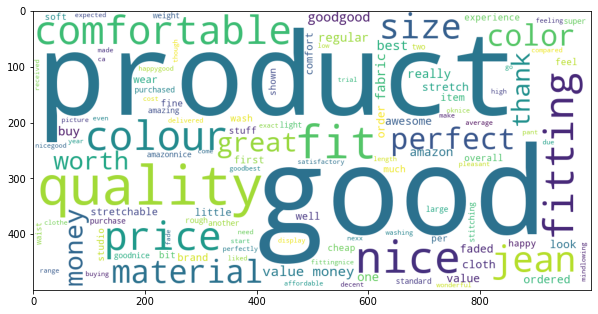

In [5]:
# GET THE WORDCLOUD FOR POSITIVE AND NEGATIVE REVIEWS 
# POSITIVE REVIEWS
def p_wc(words):
    
    pos_wc = words[words['Sentiment'] == 'Positive'].reset_index(drop = True)
    
    pos_corpus = []
    
    for i in range(0, len(pos_wc)):
        p_review = re.sub('[^a-zA-Z]', ' ', pos_wc['review'][i])
        p_review = p_review.lower()
        p_review = p_review.split()
        p_review = [lem.lemmatize(j) for j in p_review if not j in set(stopwords.words('english'))]
        p_review = ' '.join(p_review)
        pos_corpus.append(p_review)
    
    p_word_cloud = ""
    for p_row in pos_corpus:
        for p_word in p_row:
            p_word_cloud+=" ".join(p_word)
    pos_wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(p_word_cloud)
    
    rcParams['figure.figsize'] = 10, 20
    return plt.imshow(pos_wordcloud), p_word_cloud
    
img, ss =p_wc(headlines)    



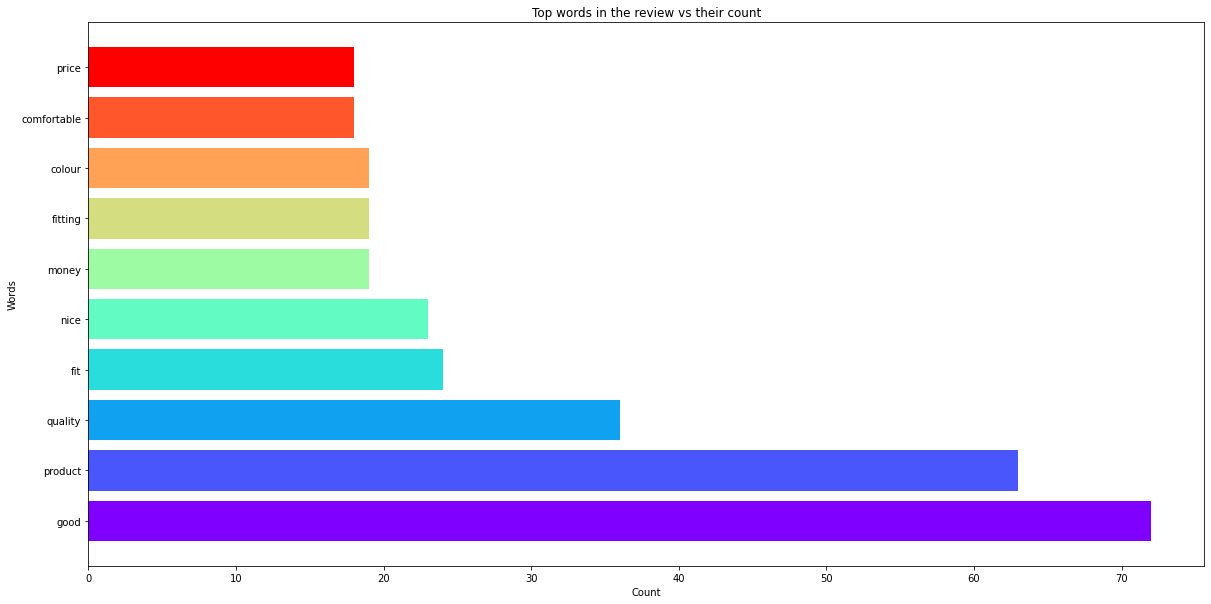

In [6]:
def top_words(wc):    
    # VERIFY TOP WORDS USING BAR PLOT
    filtered_words = [word for word in wc.split() if not word in set(stopwords.words('english'))]
    counted_words = collections.Counter(filtered_words)
    
    words = []
    counts = []
    for letter, count in counted_words.most_common(10):
        words.append(letter)
        counts.append(count)
    
    colors = cm.rainbow(np.linspace(0, 1, 10))
    rcParams['figure.figsize'] = 20, 10
    
    plt.title('Top words in the review vs their count')
    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.barh(words, counts, color=colors)

top_words(ss)

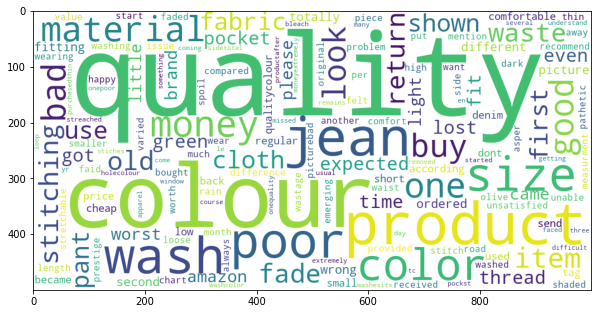

In [7]:
# NEGATIVE REVIEWS
def n_wc(wordss):
    neg_wc = wordss[wordss['Sentiment'] == 'Negative'].reset_index(drop = True)
    neg_corpus = []
    
    for k in range(0, len(neg_wc)):
        n_review = re.sub('[^a-zA-Z]', ' ', neg_wc['review'][k])
        n_review = n_review.lower()
        n_review = n_review.split()
        n_review = [lem.lemmatize(l) for l in n_review if not l in set(stopwords.words('english'))]
        n_review = ' '.join(n_review)
        neg_corpus.append(n_review)
    
    n_word_cloud = ""
    for n_row in neg_corpus:
        for n_word in n_row:
            n_word_cloud+=" ".join(n_word)
    neg_wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(n_word_cloud)
    
    rcParams['figure.figsize'] = 10, 20
    
    return plt.imshow(neg_wordcloud), n_word_cloud
    
img1, ss1 =n_wc(headlines)    




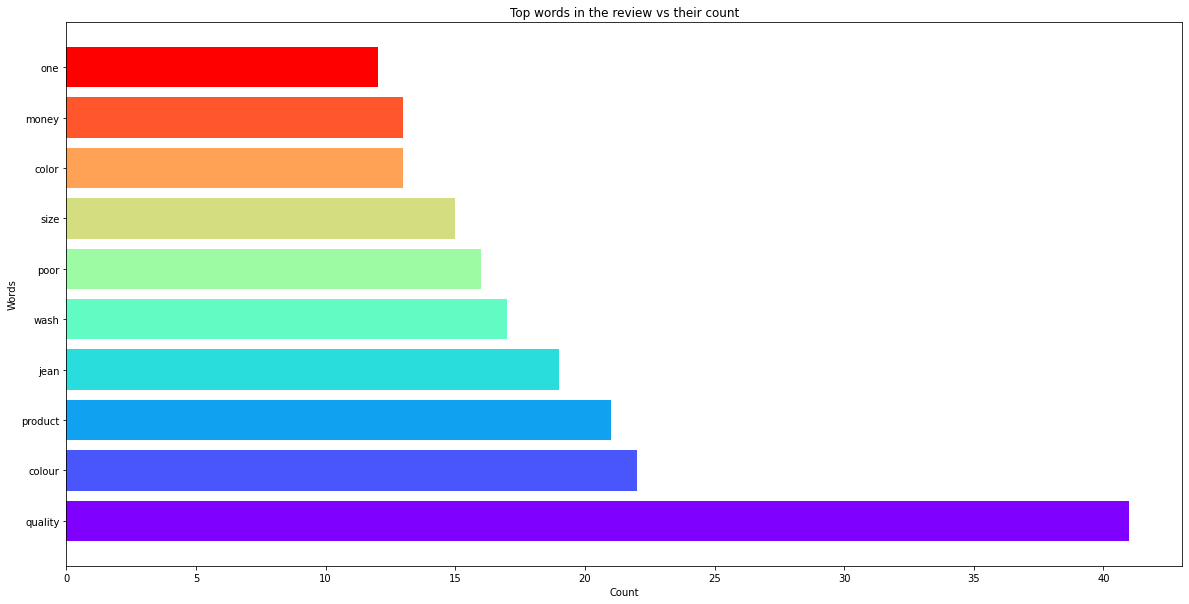

In [8]:
def n_top_words(nc):    
    # VERIFY TOP WORDS USING BAR PLOT
    filtered_words = [word for word in nc.split() if not word in set(stopwords.words('english'))]
    counted_words = collections.Counter(filtered_words)
    
    words = []
    counts = []
    for letter, count in counted_words.most_common(10):
        words.append(letter)
        counts.append(count)
    
    colors = cm.rainbow(np.linspace(0, 1, 10))
    rcParams['figure.figsize'] = 20, 10
    
    plt.title('Top words in the review vs their count')
    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.barh(words, counts, color=colors)

top_words(ss1)


In [9]:
def split_data(df2):
 
    x = df2.drop(['Sentiment'], axis = 1)
    y = df2['Sentiment']
    
    x['sent_score'] = x['review'].apply(lambda x: TextBlob(x).sentiment[0])
    x['sent_score'] = x['review'].apply(lambda x: TextBlob(x).sentiment[0])
    
    return x, y

x, y = split_data(headlines)
    



In [10]:
def vectorize_data(X, Y):
    vect = TfidfVectorizer(ngram_range = (1,2))

    x1 = X.drop(['sent_score', 'Rating'], axis = 1)
    x2 = x1['review'].to_list()
    
    vect.fit(x2)
    x3 = vect.transform(x2).toarray()
    
    x3 =pd.DataFrame(x3, columns = vect.get_feature_names())
    
    x3['sent_score'], x3['Rating'] = x['sent_score'], x['Rating']
    
    encoder = LabelEncoder()
    encoder.fit(Y)
    y1 = encoder.transform(Y)
    
    return x3, y1, vect

x3, y1, v = vectorize_data(x, y)




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [11]:
def scale_data(x_data):

    scaler = StandardScaler()

    scaler.fit(x_data)
    x4 = pd.DataFrame(scaler.transform(x3), columns = x3.columns)
    
    return x4, scaler
    
x4, s = scale_data(x3)


model = LGBMClassifier(random_state = 69, learning_rate = 0.001, max_depth = 12, n_estimators = 1000, subsample = 0.2)
model.fit(x4, y1)
       



LGBMClassifier(learning_rate=0.001, max_depth=12, n_estimators=1000,
               random_state=69, subsample=0.2)

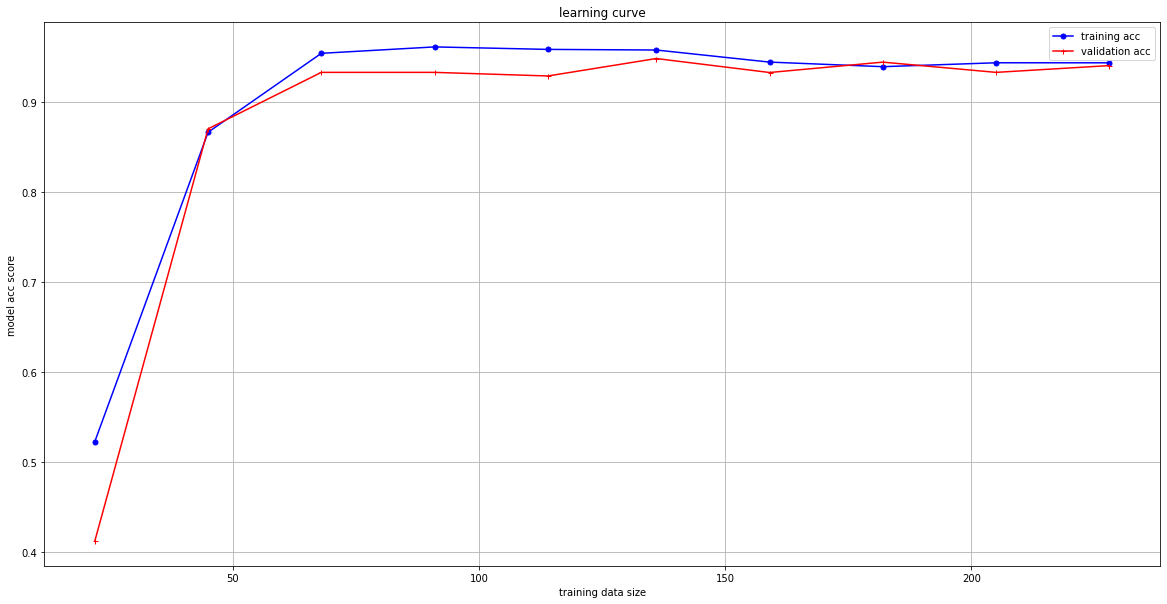

(array([0.52272727, 0.86666667, 0.95441176, 0.96153846, 0.95877193,
        0.95808824, 0.94465409, 0.93956044, 0.94390244, 0.94385965]),
 array([0.41215385, 0.87046154, 0.93323077, 0.93323077, 0.92923077,
        0.94861538, 0.93307692, 0.94461538, 0.93323077, 0.94076923]))

In [12]:
def learning_curves(estimator, X, Y, cv):
    
    train_sizes, train_scores, validation_scores = learning_curve(
                                                                  estimator, X, Y, train_sizes = np.linspace(0.1, 1.0, 10),
                                                                  scoring = 'accuracy', cv = cv
                                                                  )
    mean_train_score = train_scores.mean(axis = 1)
    mean_validation_score = validation_scores.mean(axis = 1)
    
    plt.plot(train_sizes, mean_train_score, color = 'blue', marker = 
    'o',markersize = 5, label = 'training acc')
    plt.plot(train_sizes, mean_validation_score, color = 'red', marker='+', markersize = 
    5, label = 'validation acc')
    plt.title('learning curve')
    plt.xlabel('training data size')
    plt.ylabel('model acc score')
    plt.legend()
    plt.grid()
    plt.show()
    
    return mean_train_score, mean_validation_score

learning_curves(model, x4, y1, 10)



In [13]:
# TESTING THE MODEL ON SAMPLE REVIEWS
def test_model():

    test = ["nice fitting"]
    d = v.transform(test).toarray()
    dd = pd.DataFrame(d, columns = v.get_feature_names())
    dd['sent_score'], dd['Rating'] = 0.58, 4

    ddd = pd.DataFrame(s.transform(dd))
    
    result = model.predict(ddd)
    
    if result == 0:
        print('Negative')
    else:
        print('Positive')

test101 = test_model()


Positive


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

